<!-- Notebook Header Start -->

<h1 align="center">Spike Sorting</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-10-30<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Group  || Neuromechatronics Lab
</p>

---

## 📜 Project Overview

(to populate) 

- **Objective:** (to populate)
- **Scope:** (to populate)
- **Libraries:** `Python`, `Pandas`, `SciPy`

---

## 📊 Notebook Outline

1. **Data Import & Preprocessing**


---

## 📚 References & Additional Resources

- [Github: Kilosort4](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# Libraries

In [15]:
# Imports
from pathlib import Path
from tqdm import tqdm
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

from probeinterface import write_prb
# Download channel maps for default probes
from kilosort.utils import download_probes
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import Probe, get_probe

from spikeinterface.extractors import read_intan

from kilosort import run_kilosort
from kilosort import io

# File Definitions

In [16]:
# Parameters
RAT_NAME = 'DW322'
STIMULATION = 'DRGS_2_240918_130024'
DATA_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\88 Analyzed Data\88.001 Kilosort on DW322')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

# Data Import

### defining filepath for data

In [3]:
# NOTE: You will need to select the appropriate data stream. If you run without
#       specifying `stream_id`, you will get an error message explaining what
#       each stream corresponds to.
filepath = Path(f"D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project\DW322\{RAT_NAME}\{STIMULATION}\{STIMULATION}.rhd")
recording = read_intan(filepath, stream_id='0')

no probe information is given with this data, so we will need to define it or assign one from the probe interface library.

I will first show how to create the binary file using `Spike Interface` and numpy's `memmap()`

## Import data and probe using `SpikeInterface`

In [4]:
# NOTE: Data will be saved as np.int16 by default since that is the standard
#       for ephys data. If you need a different data type for whatever reason
#       such as `np.uint16`, be sure to update this.
dtype = np.int16
filename, N, c, s, fs, probe_path = io.spikeinterface_to_binary(
    recording, DATA_DIRECTORY, data_name=f'{RAT_NAME}_{STIMULATION}_data.bin', dtype=dtype,
    chunksize=60000, export_probe=True, probe_name='probe.prb'
    )

this code will complete, but because there is no probe associated with the data, I will need to define one later on

## Import data and probe using `Numpy memmap`

### defining ouput file and loading data into binary in chunks:

In [5]:
# Define output binary file
output_file = DATA_DIRECTORY / f'{RAT_NAME}_{STIMULATION}_data_memmap.bin'

# Get data shape
num_channels = recording.get_num_channels()
num_samples = recording.get_num_frames()

# Create a memory-mapped file without using `with`
data_dtype = np.int16  # This is typically the standard for electrophysiology data
memmap_file = np.memmap(output_file, dtype=data_dtype, mode='w+', shape=(num_samples, num_channels))

# Define the chunk size for processing (e.g., 60,000 samples at a time)
chunk_size = 60000

# Loop through the data and write to the binary file in chunks
for start_idx in range(0, num_samples, chunk_size):
    end_idx = min(start_idx + chunk_size, num_samples)
    
    # Extract data chunk from the RecordingExtractor
    data_chunk = recording.get_traces(start_frame=start_idx, end_frame=end_idx)
    
    # Write the chunk to the memory-mapped file
    memmap_file[start_idx:end_idx, :] = data_chunk.astype(data_dtype)

# Explicitly flush changes to disk
memmap_file.flush()

print(f"Data successfully saved to {output_file}")


Data successfully saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.001 Kilosort on DW322\DW322_DRGS_2_240918_130024_data_memmap.bin


### exporting probe data

this will NOT run correctly, since there is no probe data

In [6]:

# Get the probe from the recording (if available)
probe = recording.get_probe()

# Define the path to save the probe configuration
probe_path = DATA_DIRECTORY / 'probe.prb'

# Save the probe configuration
write_prb(probe_path, probe)


ValueError: There is no Probe attached to this recording. Use set_probe(...) to attach one.

# Defining or assigning a probe

## downloading standard probes

you can use the `ProbeInterface` repository to define a standard probe.

You can then pull a probe from the `ProbeInterface` library

In [ ]:
# Download channel maps for default probes
from kilosort.utils import download_probes
download_probes()

manufacturer = 'neuronexus'
probe_name = 'A1x32-Edge-5mm-20-177-A32'

probe = get_probe(manufacturer, probe_name)
print(probe)

## defining a probe

Probe saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.001 Kilosort on DW322\custom_probe.prb


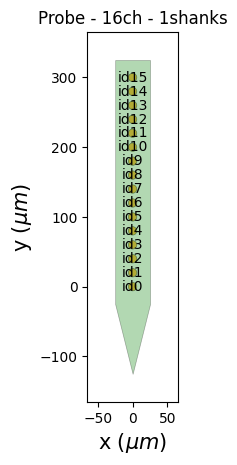

In [14]:
from probeinterface import Probe, ProbeGroup

from probeinterface import generate_linear_probe

linear_probe = generate_linear_probe(num_elec=16, ypitch=20)
plot_probe(linear_probe, with_contact_id=True)


# Create a new probe with 34 channels
probe = Probe(ndim=2)  # Creating a 2D probe representation
probe.set_contacts(positions=np.zeros((34, 2)), shapes='circle', shape_params={'radius': 10})
probe.set_device_channel_indices(np.arange(34))  # Set channel indices from 0 to 33

# Set probe type and additional info
probe.set_contact_ids([f'A-{str(i).zfill(3)}' if i < 32 else f'B-{str(i-32).zfill(3)}' for i in range(34)])
# probe.set_probing_type('monopolar')

# Wrap the probe in a ProbeGroup
probe_group = ProbeGroup()
probe_group.add_probe(probe)

# Save the new probe to a .prb file for Kilosort
probe_path = DATA_DIRECTORY / 'custom_probe.prb'
write_prb(probe_path, probe_group)

print(f"Probe saved to {probe_path}")


# Running Kilosort4

At this point, it's a good idea to open the Kilosort gui and check that the
data and probe appear to have been loaded correctly and no settings need to be
tweaked. You will need to input the path to the binary datafile, the folder where
results should be saved, and select a probe file.

```conda activate kilosort```

```python -m kilosort```

From there, you can either launch Kilosort using the GUI or run the
next notebook cell to run it through the API.

In [ ]:
# NOTE: 'n_chan_bin' is a required setting, and should reflect the total number
#       of channels in the binary file. For information on other available
#       settings, see `kilosort.run_kilosort.default_settings`.
settings = {'data_dir': DATA_DIRECTORY, 'n_chan_bin': 34}

ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = \
    run_kilosort(
        settings=settings, probe_name='neuropixPhase3B1_kilosortChanMap.mat',
        # save_preprocessed_copy=True
        )   